In [51]:
from copy import deepcopy

import matplotlib.pyplot as plt
import torch
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf

from hysteresis.base import TorchHysteresis
from hysteresis.hybrid import HybridGP
from torchAccelerator.first_order import TorchDrift
from torchAccelerator.hysteresis import HysteresisAccelerator, HysteresisQuad


def density_function(mesh_pts):
    x = mesh_pts[:, 0]
    y = mesh_pts[:, 1]
    return torch.exp(-(y - x) / 0.5)

def objective(R):
    return R[0,0]#(torch.sqrt(R[0,0]) - 2.0e-3)**2

def get_best(input):
    result = torch.empty((len(input), len(input[0])-1))
    for ii in range(len(input)):
        for jj in range(1, len(input[0])):
            result[ii][jj-1] = torch.min(input[ii][:jj])
    return result

In [52]:
from tqdm.notebook import trange


def optimize(
        accelerator_model,
        initial_beam_matrix,
        h_models,
        steps=50,
):
    iterations = steps

    # initialize with a couple of points
    train_X = torch.ones((3, 1)) * 0.75
    train_X[0] = train_X[0] * 0.0
    train_X[2] = train_X[2] * -1.0
    train_Y = torch.empty((3, 1))

    for j in range(3):
        accelerator_model.apply_fields({'q1': train_X[j, 0]})

        train_Y[j] = objective(
            accelerator_model.forward(initial_beam_matrix)
        )

    gpmodel = HybridGP(train_X.detach(), train_Y.detach(), h_models)

    for i in trange(iterations):
        UCB = UpperConfidenceBound(gpmodel, beta=2.1, maximize=False)

        bounds = torch.stack([-1.0 * torch.ones(1), torch.ones(1)])
        candidate, acq_value = optimize_acqf(
            UCB,
            bounds=bounds,
            q=1,
            num_restarts=5,
            raw_samples=20,
        )
        train_X = torch.cat((train_X, candidate))

        # apply candidate
        accelerator_model.apply_fields({'q1': candidate[0]})

        # make next measurement
        bs = objective(
            accelerator_model.forward(initial_beam_matrix)
        ).reshape(1, 1)
        train_Y = torch.cat((train_Y.clone(), bs.clone()))

        # train new model
        gpmodel = HybridGP(train_X.detach(), train_Y.detach(), h_models)

    return train_X, train_Y, accelerator_model, gpmodel

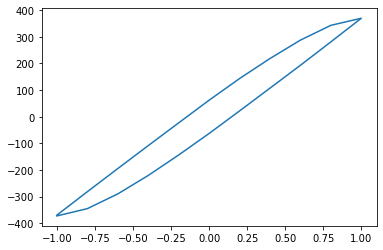

In [53]:
# hysteresis model
H = TorchHysteresis(mesh_scale=0.1, trainable=False)
dens = density_function(H.mesh_points)
H.h_min = -1.0
H.hysterion_density = dens
H.scale = torch.tensor(500.0)

test_H = deepcopy(H)
test_applied_fields = torch.cat(
    (torch.linspace(-1,1,11) , torch.flipud(torch.linspace(-1,1,11)))
)
test_H.applied_fields = test_applied_fields
with torch.no_grad():
    M = test_H.predict_magnetization_from_applied_fields()

fig,ax = plt.subplots()
ax.plot(test_applied_fields, M)

  0%|          | 0/10 [00:00<?, ?it/s]

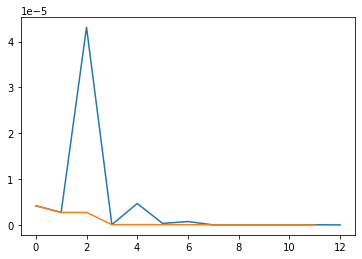

In [54]:
# accelerator model
hmodels = [deepcopy(H)] * 1

# define quadrupoles
d0 = TorchDrift("d0", torch.tensor(1.0))
q1 = HysteresisQuad("q1", torch.tensor(0.1), hmodels[0])
d1 = TorchDrift("d1", torch.tensor(0.1))
D = [d1] * 10

HA = HysteresisAccelerator([d0, q1] + D, allow_duplicates=True)

init_beam_matrix = torch.eye(6) * 1.0e-8

# set x_rms beam size to 1 mm and rms divergence to 0.1 mrad
init_beam_matrix[0, 0] = 1.0e-3 ** 2
init_beam_matrix[1, 1] = 1.0e-4 ** 2
init_beam_matrix[2, 2] = 1.0e-3 ** 2
init_beam_matrix[3, 3] = 1.0e-4 ** 2
R = init_beam_matrix

# do optimization
p, l, accelerator_model, gp_hybrid = optimize(
    deepcopy(HA),
    R,
    hmodels,
    steps=10,
)


# plot the optimizer trace

fig,ax = plt.subplots()
best = get_best(l.reshape(1,-1))
ax.plot(l.detach())
ax.plot(best.detach().flatten())

tensor(4.6156e-09, grad_fn=<SelectBackward>)
tensor([0.0399])


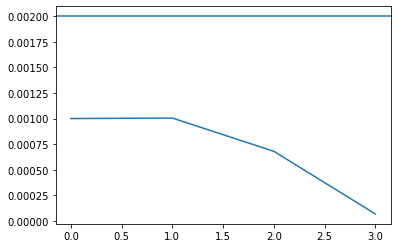

In [55]:
# plot beam size along beamline
#accelerator_model.apply_fields({'q1': torch.zeros(1)})
beam_matrix = accelerator_model.forward(init_beam_matrix, full=False)
print(objective(beam_matrix[-1]))
print(p[-1])

fig,ax = plt.subplots()
ax.plot(torch.sqrt(beam_matrix[:, 0, 0]).detach())
ax.axhline(2e-3)

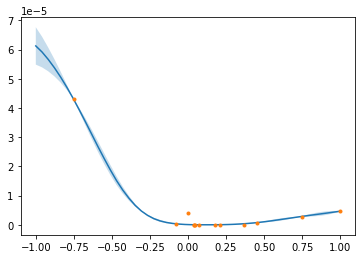

In [59]:
# now use the Hybrid GP model to recover the best observed point by using the
# posterior mean acquisition function
acq = UpperConfidenceBound(gp_hybrid, beta = 0.00001, maximize=False)

# plot model and acq at this state
test_x = torch.linspace(-1,1,50)
with torch.no_grad():
    post = gp_hybrid(test_x.unsqueeze(1), untransform_posterior=True)
    mean = post.mean.flatten()
    std = torch.sqrt(post.variance.flatten())

fig, ax = plt.subplots()
ax.plot(test_x, mean)
ax.plot(p, l.detach(),'.')
ax.fill_between(test_x, mean - std, mean + std, alpha=0.25)

final setpoint:tensor([0.1318])
objective value : 4.615574589195148e-09
best candidate from optimization: tensor([0.0710])
objective value : 1.2228515977596999e-09


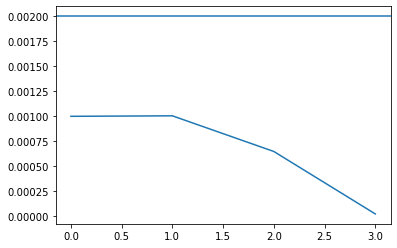

In [57]:



bounds = torch.stack([-1.0 * torch.ones(1), torch.ones(1)])
final_candidate, acq_value = optimize_acqf(
    acq,
    bounds=bounds,
    q=1,
    num_restarts=20,
    raw_samples=100,
    batch_initial_conditions=p[torch.argmin(l)].reshape(1,-1)
)
print(f'final setpoint:{final_candidate}')
print(f'objective value : {objective(beam_matrix[-1])}')
best_candidate_from_optimization = p[torch.argmin(l)]
print(f"best candidate from optimization: {best_candidate_from_optimization}")
print(f'objective value : {torch.min(l)}')

# apply final candidate to accelerator
accelerator_model.apply_fields(
    {
        "q1": final_candidate[0]
    }
)

# plot beam size along beamline
beam_matrix = accelerator_model.forward(init_beam_matrix, full=False)

fig,ax = plt.subplots()
ax.plot(torch.sqrt(beam_matrix[:, 0, 0]).detach())
ax.axhline(2e-3)
